In [48]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MySparkApp") \
    .enableHiveSupport() \
    .getOrCreate()

df = spark.read.csv("video_game_sales.csv", header=True, inferSchema=True)
df.show(5)

+----+--------------------+--------+----+------------+---------+--------+--------+--------+-----------+------------+
|rank|                name|platform|year|       genre|publisher|na_sales|eu_sales|jp_sales|other_sales|global_sales|
+----+--------------------+--------+----+------------+---------+--------+--------+--------+-----------+------------+
|   1|          Wii Sports|     Wii|2006|      Sports| Nintendo|   41.49|   29.02|    3.77|       8.46|       82.74|
|   2|   Super Mario Bros.|     NES|1985|    Platform| Nintendo|   29.08|    3.58|    6.81|       0.77|       40.24|
|   3|      Mario Kart Wii|     Wii|2008|      Racing| Nintendo|   15.85|   12.88|    3.79|       3.31|       35.82|
|   4|   Wii Sports Resort|     Wii|2009|      Sports| Nintendo|   15.75|   11.01|    3.28|       2.96|        33.0|
|   5|Pokemon Red/Pokem...|      GB|1996|Role-Playing| Nintendo|   11.27|    8.89|   10.22|        1.0|       31.37|
+----+--------------------+--------+----+------------+---------+

In [49]:
result_df = df.groupBy("publisher").agg({"global_sales": "sum"})

result_df.show()

+--------------------+-------------------+
|           publisher|  sum(global_sales)|
+--------------------+-------------------+
|        Funbox Media| 0.9100000000000001|
|         Media Rings|               0.65|
| Iceberg Interactive|               0.08|
|         Tigervision|               1.42|
|   bitComposer Games|0.41000000000000003|
|                 3DO| 10.120000000000001|
|           Telegames| 1.0299999999999998|
|   Jack of All Games|0.42000000000000004|
|Nihon Falcom Corp...|               0.77|
|               Sting|               0.65|
|         id Software|               0.03|
|        IE Institute| 0.9600000000000002|
|           Game Life|0.30000000000000004|
| Karin Entertainment|               0.02|
|     Evolution Games|               0.07|
|              Takuyo|               0.01|
|          Infogrames| 16.340000000000003|
|  Illusion Softworks|                0.7|
|          Enterbrain| 2.2299999999999995|
|                 Elf|               0.64|
+----------

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

# Переименование колонки для удобства
result_df = result_df.withColumnRenamed("sum(global_sales)", "total_global_sales")

# Преобразование Spark DataFrame в Pandas DataFrame
result_pd = result_df.toPandas()

print(result_pd.isnull().sum()) 
result_pd = result_pd.dropna()

publisher             1
total_global_sales    0
dtype: int64


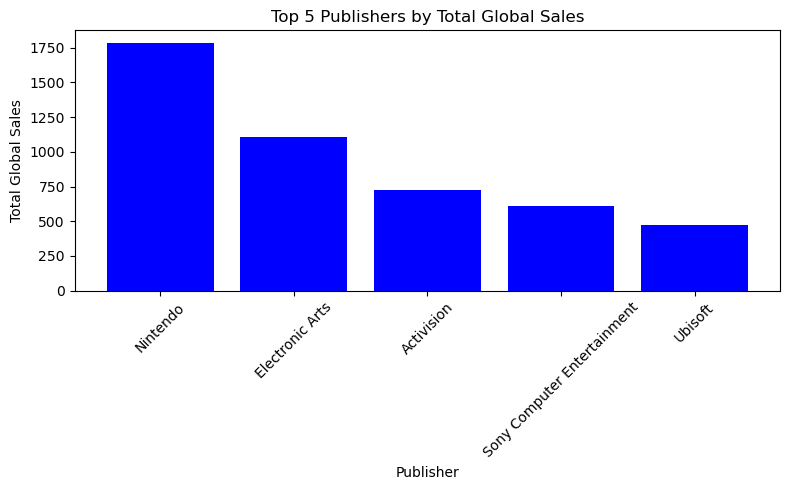

In [60]:
# Построение графика

top_publishers = result_pd.nlargest(5, 'total_global_sales')

plt.figure(figsize=(8, 5))
plt.bar(top_publishers['publisher'], top_publishers['total_global_sales'], color='blue')
plt.title('Top 5 Publishers by Total Global Sales')
plt.xticks(rotation=45)
plt.ylabel('Total Global Sales')
plt.xlabel('Publisher')
plt.tight_layout()
plt.show()

In [61]:
spark.stop()

### Интеграция с Hive

In [39]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MySparkApp") \
    .config("spark.sql.catalogImplementation", "hive") \
    .enableHiveSupport() \
    .getOrCreate()

df = spark.read.csv("video_game_sales.csv", header=True, inferSchema=True)
result_df = df.groupBy("publisher").agg({"global_sales": "sum"})

spark.sql("""
CREATE TABLE IF NOT EXISTS publisher_data (
    publisher STRING,
    global_sales FLOAT
) USING hive
""")

# Запись данных напрямую в publisher_data
result_df.write \
    .mode("append") \
    .insertInto("publisher_data")

# Проверка всех данных в publisher_data
hive_results = spark.sql("SELECT * FROM publisher_data")
hive_results.show(10)

+--------------------+------------+
|           publisher|global_sales|
+--------------------+------------+
|        Funbox Media|        0.91|
|         Media Rings|        0.65|
| Iceberg Interactive|        0.08|
|         Tigervision|        1.42|
|   bitComposer Games|        0.41|
|                 3DO|       10.12|
|           Telegames|        1.03|
|   Jack of All Games|        0.42|
|Nihon Falcom Corp...|        0.77|
|               Sting|        0.65|
+--------------------+------------+
only showing top 10 rows



In [40]:
# Проверка количества строк в publisher_data
count_results = spark.sql("SELECT COUNT(*) FROM publisher_data")
count_results.show()

+--------+
|count(1)|
+--------+
|    1737|
+--------+



In [41]:
# Выполнение SQL-запроса к таблице publisher_data с порогом global_sales
filtered_results = spark.sql("SELECT * FROM publisher_data WHERE global_sales > 500")
filtered_results.show()

+--------------------+------------+
|           publisher|global_sales|
+--------------------+------------+
|     Electronic Arts|     1110.32|
|Sony Computer Ent...|       607.5|
|          Activision|      727.46|
|            Nintendo|     1786.56|
|     Electronic Arts|     1110.32|
|Sony Computer Ent...|       607.5|
|          Activision|      727.46|
|            Nintendo|     1786.56|
|     Electronic Arts|     1110.32|
|Sony Computer Ent...|       607.5|
|          Activision|      727.46|
|            Nintendo|     1786.56|
+--------------------+------------+



Подключение к hdfs, если изменить имя файла, сразу возникает ошибка.  
То есть он видит, когда файла нет в hdfs.   
Но мой файл все равно не загружает.

In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MySparkApp") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .getOrCreate()

df = spark.read.csv("video_game_sales.csv", header=True, inferSchema=True, mode='DROPMALFORMED')
df.show(5)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [2]:
spark.stop()